# FD-DeepLoc inference example
The inference process includes the following steps:
1. Set the path for the trained network model and experimental images.
2. Set necessary parameters.
3. Load the network and plot the training process.
4. Check a specific experiment frame and corresponding network's multi-channel predictions.
5. Start inferring.
6. Load the ground-truth and assess(optional). 

In [1]:
import pickle
import sys
import seaborn as sns

sns.set_style("white")
sys.setrecursionlimit(10000)
%matplotlib notebook

from fd_deeploc_core import *
from local_utils import *

## 1. Set the path for the trained network model and experimental images.
The printed `save_path` is where to save the network's predicted molecule list.

In [2]:
# set the trained model path and the image path that need to be analysed
network_path = "./example_data/Li_Lab_DMO_Tetrapod6um_mito_TOM20/example_FD-DeepLoc.pkl"
image_path = "./example_data/Li_Lab_DMO_Tetrapod6um_mito_TOM20/example_frames.tif"
save_path = './'+os.path.split(network_path)[-1].split('.')[0]+'_'+os.path.split(image_path)[-1].split('.')[0]+'.csv'
print(save_path)

./example_FD-DeepLoc_example_frames.csv


## 2. Set necessary parameters.
* `stack_giga` is the size of sequentially processed images (in gigabyte), it is only an approximate value, set it small when you have limited RAM.
* `pixel_size` is the physical size of each camera pixel (_xy_ in nm).
* `start_field_pos`: **Important**, it is the **_xy_** position of the upper left pixel of the input images in the entire FOV. For example, `start_field_pos` [102,41] means the upper left pixel (namely local position [0,0]) of the input images is located at [102,41] of the whole FOV. Thus CoordConv can get the global position of the input images.

In [3]:
# set the size of file to be processed sequentially, unit: gigabyte
stack_giga = 0.5
pixel_size = [110, 110]
start_field_pos = [0, 0]

## 3. Load the network and plot the training process.

<IPython.core.display.Javascript object>


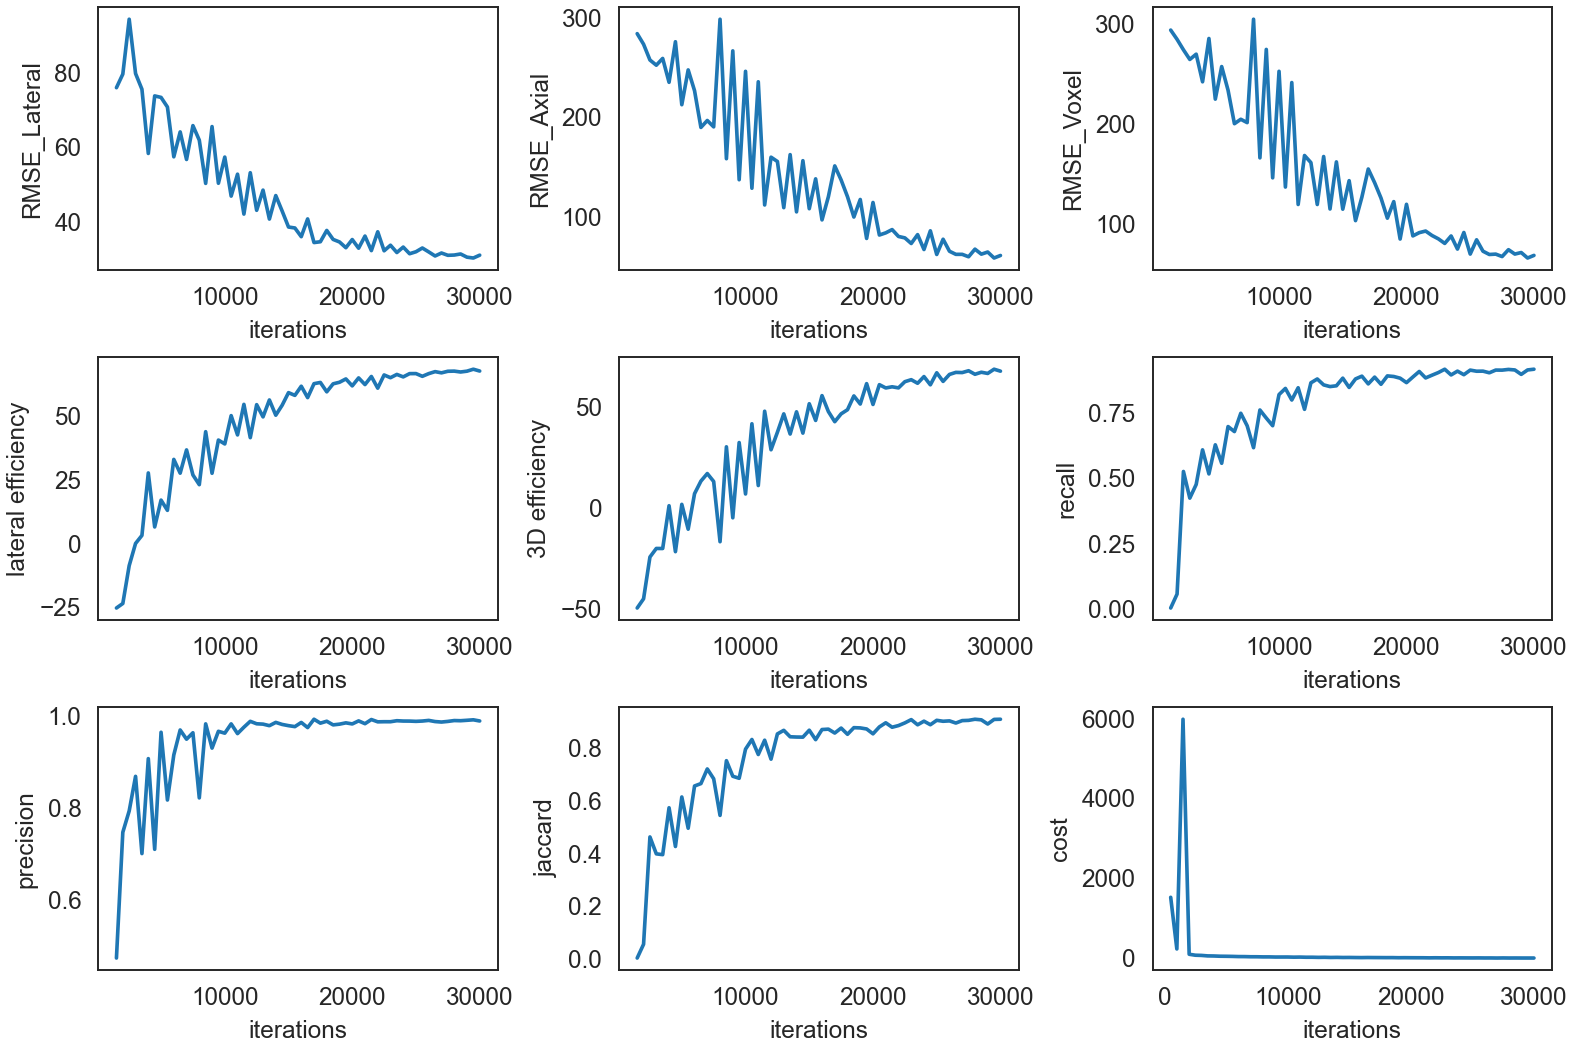

In [4]:
# load the completely trained FD_DECODE model
with open(network_path, 'rb') as f:
    model = pickle.load(f)

# plot performance during the training
plot_train_record(model)

## 4. Check a specific experiment frame and corresponding network's multi-channel predictions.
* `plot_num`: The number of specific image that will be checked, better $\geq$ 5 (considering temporal context and background estimation)
* `nms`: If False, only use a simple threshold `nms_thre` to filter probability channel to get the deterministic pixels. If True, probability channel pixels with value>`candi_thre` will be treated as candidates for local maximum searching. Then add the values from the 4 adjacent pixels to local maximums and filter the modified probability channel with the threshold `nms_thre` to get deterministic pixel-level localizations.
* `rescale_xy`: Rescales _x_ and _y_ offsets (inplace) so that they are distributed uniformly within [-0.5, 0.5] to correct for biased outputs (usually False).
* `pixel_size`,`start_field_pos` are explained before.
* `divide_and_conquer`: Divide the large images into small sub-area images. This is necessary as large input images may lead to GPU memory problem, this enables the network process the large images by sub-areas.
* `win_size`: If `divide_and_conquer`=True, set the size of sub-areas to be analyzed, must be a multiple of 4 (avoid error when down-sampling or up-sampling).
* `padding`: If `divide_and_conquer`=True and `padding`=True, this will segment a larger area (20 pixels) than `win_size` and traverse with overlap to avoid error from incomplete PSFs at margin.

TiffPage: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'


processing area:49/49, input field_xy:[1516 1607 1516 1607], use_coordconv:True, retain locs in area:[1536, 1607, 1536, 1607], aber_map size:(1608, 1608, 23)


<IPython.core.display.Javascript object>


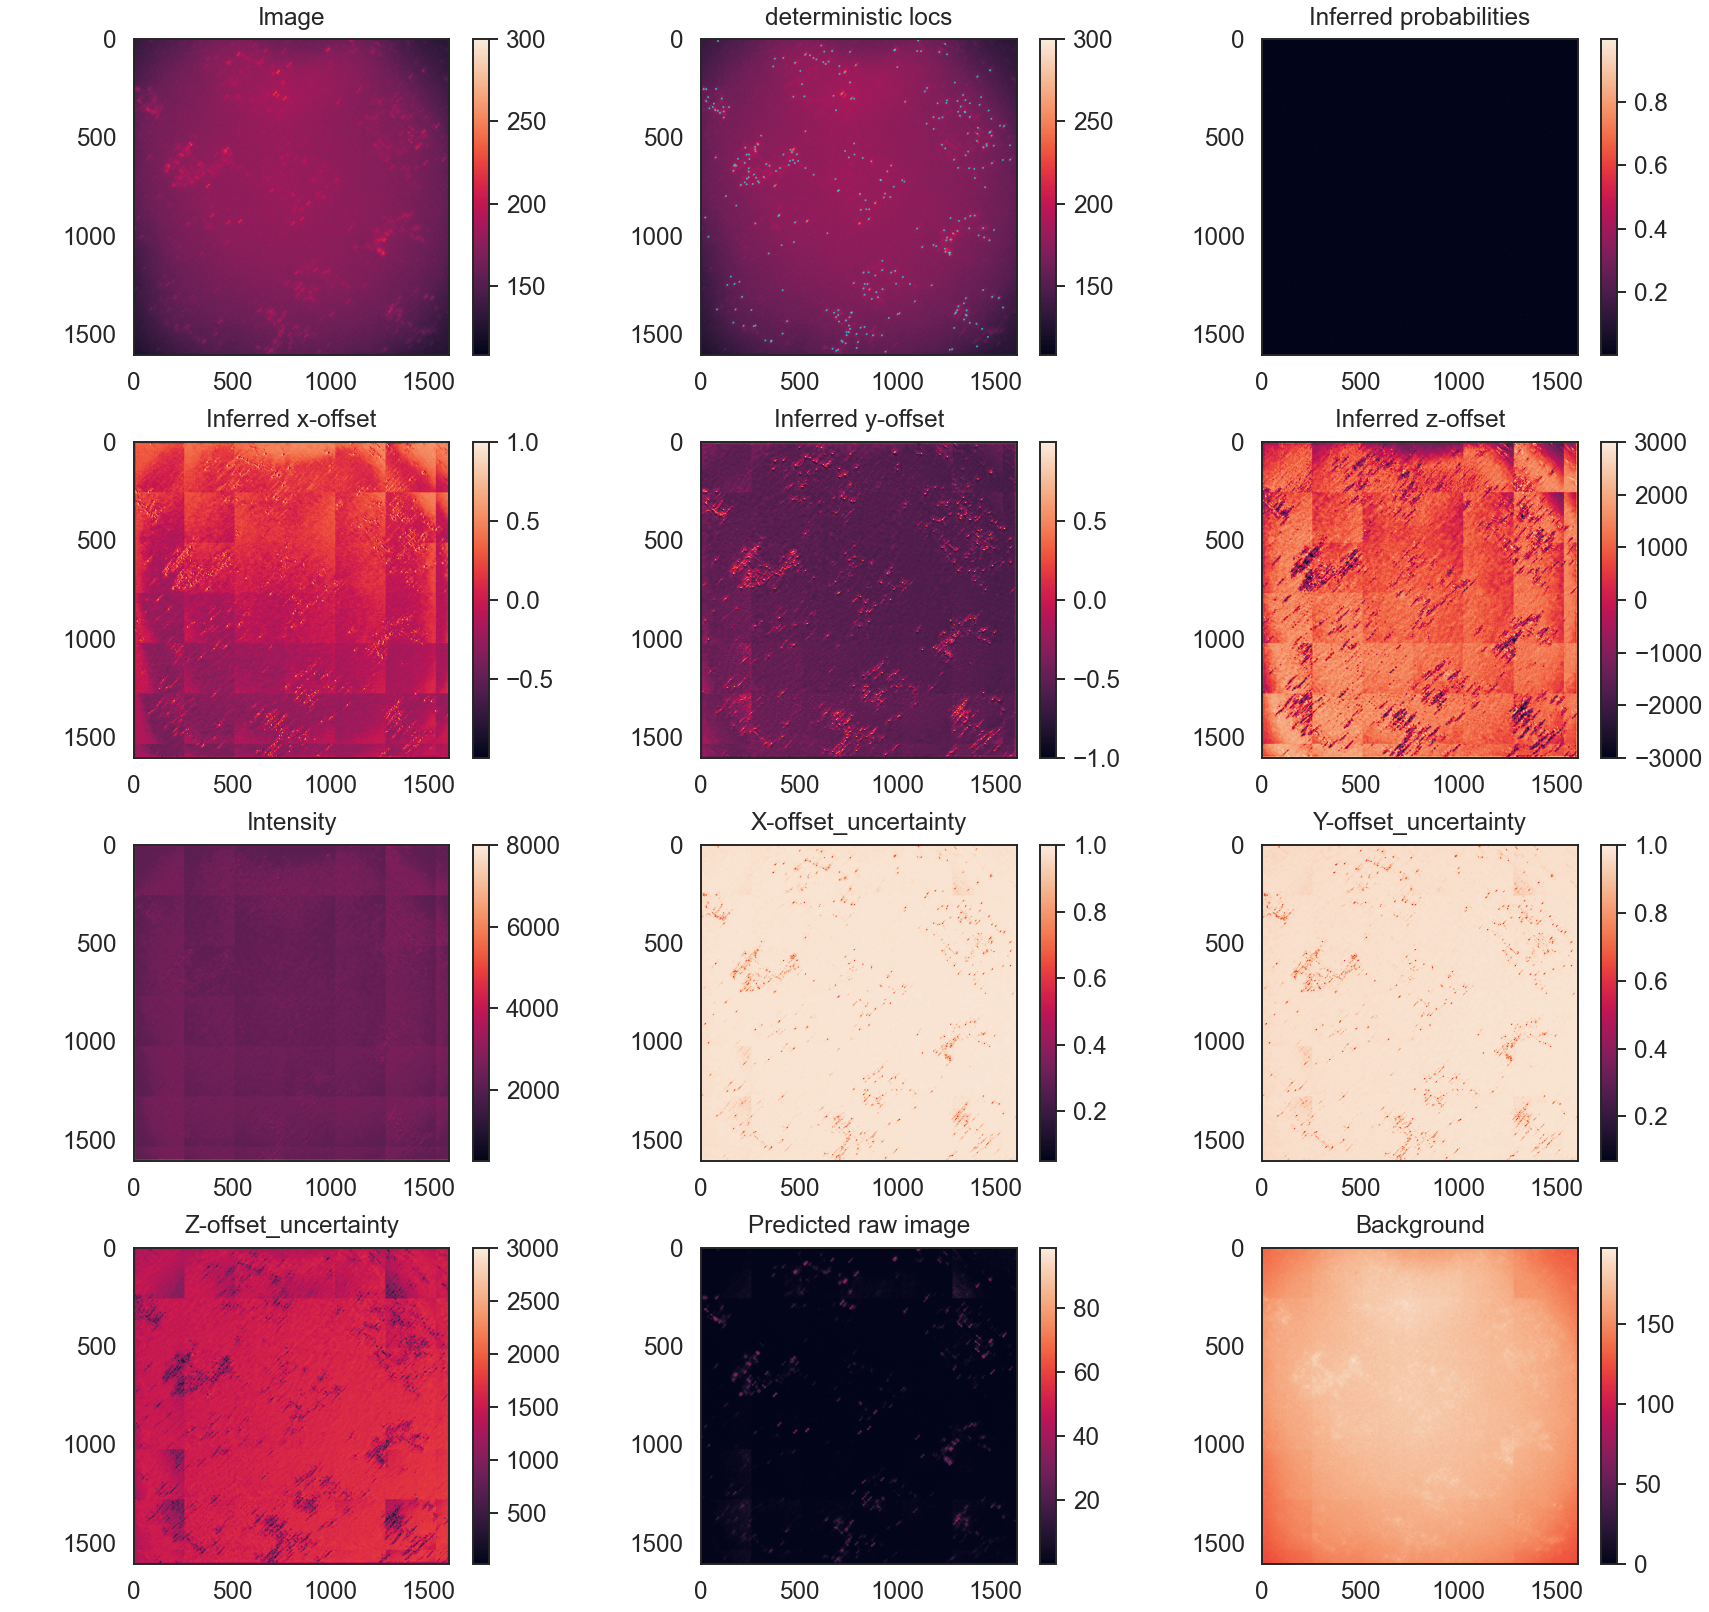

<IPython.core.display.Javascript object>


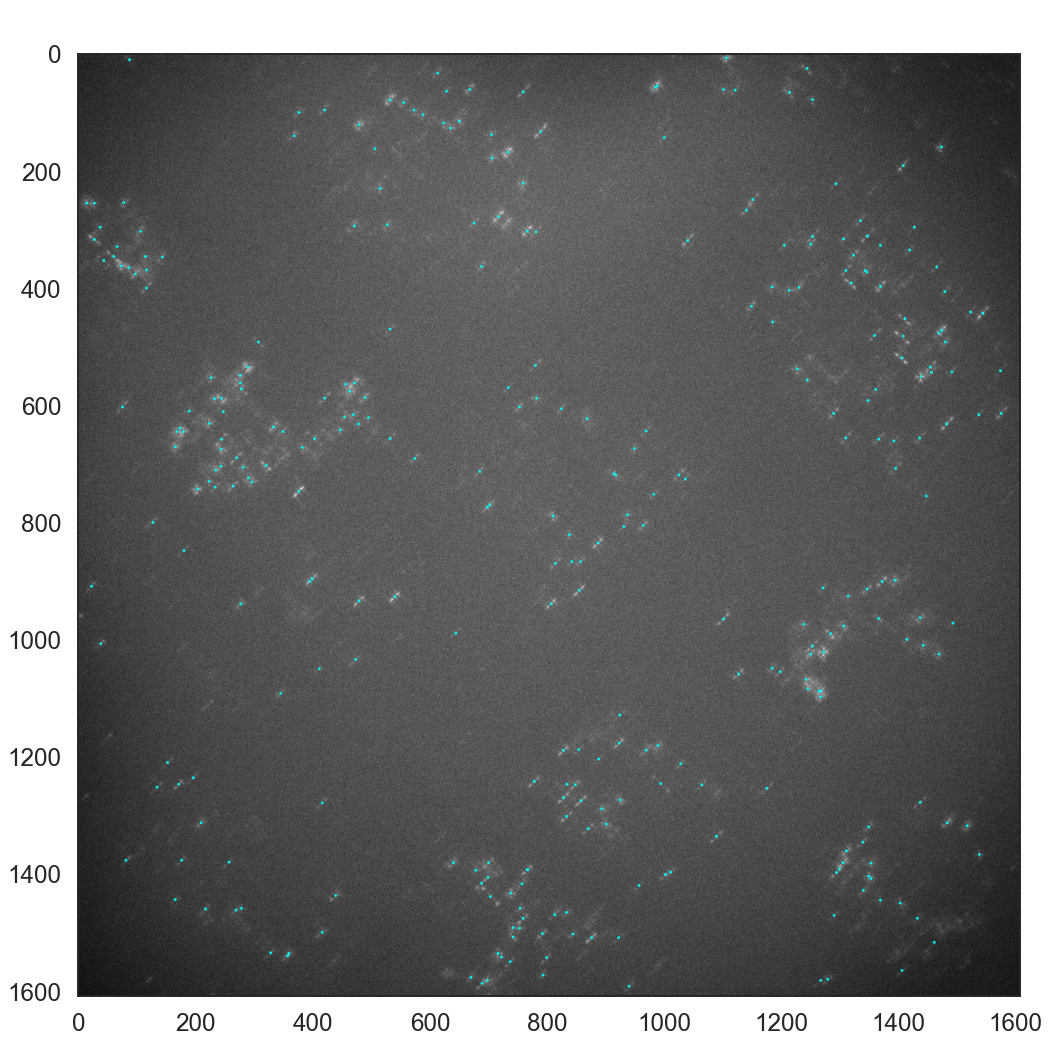

In [5]:
# check the specified frame and corresponding multi-channel output
check_specific_frame_output(plot_num=5, model=model, image_path=image_path, eval_csv=None,
                            nms=True, candi_thre=0.3, nms_thre=0.3, rescale_xy=False, pixel_size=pixel_size,
                            start_field_pos=start_field_pos, divide_and_conquer=True, win_size=256, padding=True)

## 5. Start inferring.
Read big tiff and predict, save the predictions every finish processing `stack_giga`-sized SMLM images, even some accidents happen you will not lose all results. If there is already a prediction file with the same name as `save_path`, inference will start from the last saved frame number in the `save_path` file. We recommend using SMAP to postprocess the prediction list (drift correction, grouping, etc.) and render the super-resolution image (Ries, J. SMAP: a modular super-resolution microscopy analysis platform for SMLM data. Nat Methods 17, 870–872 (2020). https://doi.org/10.1038/s41592-020-0938-1). 
* The parameters haven been explained before.

In [6]:
# read big tiff and predict, save the predictions every finish processing stack_giga-sized SMLM images,
# even some accidents happen you will not lose all results
total_shape,fov_size = read_bigtiff_and_predict(model, image_path, stack_giga=stack_giga, batch_size=10,
                                                use_tqdm=True, nms=True, candi_thre=0.3, nms_thre=0.3,
                                                rescale_xy=False, pixel_size=pixel_size, start_field_pos=start_field_pos, 
                                                divide_and_conquer=True, win_size=256, padding=True, save_path=save_path)

TiffPage: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'


the file to save the predictions is:  ./example_FD-DeepLoc_example_frames.csv
stack: 1/8, contain imgs: 100, already analyzed:0/800

processing area:1/49, input field_xy:[  0 275   0 275], use_coordconv:True, retain locs in area:[0, 255, 0, 255], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.97it/s]



processing area:2/49, input field_xy:[236 531   0 275], use_coordconv:True, retain locs in area:[256, 511, 0, 255], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.04it/s]



processing area:3/49, input field_xy:[492 787   0 275], use_coordconv:True, retain locs in area:[512, 767, 0, 255], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.20it/s]



processing area:4/49, input field_xy:[ 748 1043    0  275], use_coordconv:True, retain locs in area:[768, 1023, 0, 255], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.21it/s]



processing area:5/49, input field_xy:[1004 1299    0  275], use_coordconv:True, retain locs in area:[1024, 1279, 0, 255], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.21it/s]



processing area:6/49, input field_xy:[1260 1555    0  275], use_coordconv:True, retain locs in area:[1280, 1535, 0, 255], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.20it/s]



processing area:7/49, input field_xy:[1516 1607    0  275], use_coordconv:True, retain locs in area:[1536, 1607, 0, 255], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 27.88it/s]



processing area:8/49, input field_xy:[  0 275 236 531], use_coordconv:True, retain locs in area:[0, 255, 256, 511], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.05it/s]



processing area:9/49, input field_xy:[236 531 236 531], use_coordconv:True, retain locs in area:[256, 511, 256, 511], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.38it/s]



processing area:10/49, input field_xy:[492 787 236 531], use_coordconv:True, retain locs in area:[512, 767, 256, 511], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.59it/s]



processing area:11/49, input field_xy:[ 748 1043  236  531], use_coordconv:True, retain locs in area:[768, 1023, 256, 511], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.63it/s]



processing area:12/49, input field_xy:[1004 1299  236  531], use_coordconv:True, retain locs in area:[1024, 1279, 256, 511], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.62it/s]



processing area:13/49, input field_xy:[1260 1555  236  531], use_coordconv:True, retain locs in area:[1280, 1535, 256, 511], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.61it/s]



processing area:14/49, input field_xy:[1516 1607  236  531], use_coordconv:True, retain locs in area:[1536, 1607, 256, 511], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 26.36it/s]



processing area:15/49, input field_xy:[  0 275 492 787], use_coordconv:True, retain locs in area:[0, 255, 512, 767], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.19it/s]



processing area:16/49, input field_xy:[236 531 492 787], use_coordconv:True, retain locs in area:[256, 511, 512, 767], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.63it/s]



processing area:17/49, input field_xy:[492 787 492 787], use_coordconv:True, retain locs in area:[512, 767, 512, 767], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.64it/s]



processing area:18/49, input field_xy:[ 748 1043  492  787], use_coordconv:True, retain locs in area:[768, 1023, 512, 767], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.65it/s]



processing area:19/49, input field_xy:[1004 1299  492  787], use_coordconv:True, retain locs in area:[1024, 1279, 512, 767], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.65it/s]



processing area:20/49, input field_xy:[1260 1555  492  787], use_coordconv:True, retain locs in area:[1280, 1535, 512, 767], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.60it/s]



processing area:21/49, input field_xy:[1516 1607  492  787], use_coordconv:True, retain locs in area:[1536, 1607, 512, 767], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 26.58it/s]



processing area:22/49, input field_xy:[   0  275  748 1043], use_coordconv:True, retain locs in area:[0, 255, 768, 1023], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.24it/s]



processing area:23/49, input field_xy:[ 236  531  748 1043], use_coordconv:True, retain locs in area:[256, 511, 768, 1023], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.64it/s]



processing area:24/49, input field_xy:[ 492  787  748 1043], use_coordconv:True, retain locs in area:[512, 767, 768, 1023], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.61it/s]



processing area:25/49, input field_xy:[ 748 1043  748 1043], use_coordconv:True, retain locs in area:[768, 1023, 768, 1023], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.60it/s]



processing area:26/49, input field_xy:[1004 1299  748 1043], use_coordconv:True, retain locs in area:[1024, 1279, 768, 1023], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.57it/s]



processing area:27/49, input field_xy:[1260 1555  748 1043], use_coordconv:True, retain locs in area:[1280, 1535, 768, 1023], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.57it/s]



processing area:28/49, input field_xy:[1516 1607  748 1043], use_coordconv:True, retain locs in area:[1536, 1607, 768, 1023], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 26.73it/s]



processing area:29/49, input field_xy:[   0  275 1004 1299], use_coordconv:True, retain locs in area:[0, 255, 1024, 1279], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.21it/s]



processing area:30/49, input field_xy:[ 236  531 1004 1299], use_coordconv:True, retain locs in area:[256, 511, 1024, 1279], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.66it/s]



processing area:31/49, input field_xy:[ 492  787 1004 1299], use_coordconv:True, retain locs in area:[512, 767, 1024, 1279], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.67it/s]



processing area:32/49, input field_xy:[ 748 1043 1004 1299], use_coordconv:True, retain locs in area:[768, 1023, 1024, 1279], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.62it/s]



processing area:33/49, input field_xy:[1004 1299 1004 1299], use_coordconv:True, retain locs in area:[1024, 1279, 1024, 1279], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.68it/s]



processing area:34/49, input field_xy:[1260 1555 1004 1299], use_coordconv:True, retain locs in area:[1280, 1535, 1024, 1279], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.63it/s]



processing area:35/49, input field_xy:[1516 1607 1004 1299], use_coordconv:True, retain locs in area:[1536, 1607, 1024, 1279], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 26.69it/s]



processing area:36/49, input field_xy:[   0  275 1260 1555], use_coordconv:True, retain locs in area:[0, 255, 1280, 1535], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.23it/s]



processing area:37/49, input field_xy:[ 236  531 1260 1555], use_coordconv:True, retain locs in area:[256, 511, 1280, 1535], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.67it/s]



processing area:38/49, input field_xy:[ 492  787 1260 1555], use_coordconv:True, retain locs in area:[512, 767, 1280, 1535], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.63it/s]



processing area:39/49, input field_xy:[ 748 1043 1260 1555], use_coordconv:True, retain locs in area:[768, 1023, 1280, 1535], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.65it/s]



processing area:40/49, input field_xy:[1004 1299 1260 1555], use_coordconv:True, retain locs in area:[1024, 1279, 1280, 1535], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.60it/s]



processing area:41/49, input field_xy:[1260 1555 1260 1555], use_coordconv:True, retain locs in area:[1280, 1535, 1280, 1535], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.63it/s]



processing area:42/49, input field_xy:[1516 1607 1260 1555], use_coordconv:True, retain locs in area:[1536, 1607, 1280, 1535], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 26.70it/s]



processing area:43/49, input field_xy:[   0  275 1516 1607], use_coordconv:True, retain locs in area:[0, 255, 1536, 1607], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 28.92it/s]



processing area:44/49, input field_xy:[ 236  531 1516 1607], use_coordconv:True, retain locs in area:[256, 511, 1536, 1607], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 26.91it/s]



processing area:45/49, input field_xy:[ 492  787 1516 1607], use_coordconv:True, retain locs in area:[512, 767, 1536, 1607], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 27.27it/s]



processing area:46/49, input field_xy:[ 748 1043 1516 1607], use_coordconv:True, retain locs in area:[768, 1023, 1536, 1607], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 27.15it/s]



processing area:47/49, input field_xy:[1004 1299 1516 1607], use_coordconv:True, retain locs in area:[1024, 1279, 1536, 1607], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 27.13it/s]



processing area:48/49, input field_xy:[1260 1555 1516 1607], use_coordconv:True, retain locs in area:[1280, 1535, 1536, 1607], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 27.01it/s]



processing area:49/49, input field_xy:[1516 1607 1516 1607], use_coordconv:True, retain locs in area:[1536, 1607, 1536, 1607], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 70.28it/s]



stack: 2/8, contain imgs: 100, already analyzed:100/800

processing area:1/49, input field_xy:[  0 275   0 275], use_coordconv:True, retain locs in area:[0, 255, 0, 255], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.94it/s]



processing area:2/49, input field_xy:[236 531   0 275], use_coordconv:True, retain locs in area:[256, 511, 0, 255], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.02it/s]



processing area:3/49, input field_xy:[492 787   0 275], use_coordconv:True, retain locs in area:[512, 767, 0, 255], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.15it/s]



processing area:4/49, input field_xy:[ 748 1043    0  275], use_coordconv:True, retain locs in area:[768, 1023, 0, 255], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.14it/s]



processing area:5/49, input field_xy:[1004 1299    0  275], use_coordconv:True, retain locs in area:[1024, 1279, 0, 255], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.21it/s]



processing area:6/49, input field_xy:[1260 1555    0  275], use_coordconv:True, retain locs in area:[1280, 1535, 0, 255], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.08it/s]



processing area:7/49, input field_xy:[1516 1607    0  275], use_coordconv:True, retain locs in area:[1536, 1607, 0, 255], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 28.12it/s]



processing area:8/49, input field_xy:[  0 275 236 531], use_coordconv:True, retain locs in area:[0, 255, 256, 511], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.14it/s]



processing area:9/49, input field_xy:[236 531 236 531], use_coordconv:True, retain locs in area:[256, 511, 256, 511], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.45it/s]



processing area:10/49, input field_xy:[492 787 236 531], use_coordconv:True, retain locs in area:[512, 767, 256, 511], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.40it/s]



processing area:11/49, input field_xy:[ 748 1043  236  531], use_coordconv:True, retain locs in area:[768, 1023, 256, 511], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.34it/s]



processing area:12/49, input field_xy:[1004 1299  236  531], use_coordconv:True, retain locs in area:[1024, 1279, 256, 511], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.43it/s]



processing area:13/49, input field_xy:[1260 1555  236  531], use_coordconv:True, retain locs in area:[1280, 1535, 256, 511], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.58it/s]



processing area:14/49, input field_xy:[1516 1607  236  531], use_coordconv:True, retain locs in area:[1536, 1607, 256, 511], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 26.58it/s]



processing area:15/49, input field_xy:[  0 275 492 787], use_coordconv:True, retain locs in area:[0, 255, 512, 767], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.24it/s]



processing area:16/49, input field_xy:[236 531 492 787], use_coordconv:True, retain locs in area:[256, 511, 512, 767], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.61it/s]



processing area:17/49, input field_xy:[492 787 492 787], use_coordconv:True, retain locs in area:[512, 767, 512, 767], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.63it/s]



processing area:18/49, input field_xy:[ 748 1043  492  787], use_coordconv:True, retain locs in area:[768, 1023, 512, 767], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.63it/s]



processing area:19/49, input field_xy:[1004 1299  492  787], use_coordconv:True, retain locs in area:[1024, 1279, 512, 767], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.64it/s]



processing area:20/49, input field_xy:[1260 1555  492  787], use_coordconv:True, retain locs in area:[1280, 1535, 512, 767], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.64it/s]



processing area:21/49, input field_xy:[1516 1607  492  787], use_coordconv:True, retain locs in area:[1536, 1607, 512, 767], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 26.59it/s]



processing area:22/49, input field_xy:[   0  275  748 1043], use_coordconv:True, retain locs in area:[0, 255, 768, 1023], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.18it/s]



processing area:23/49, input field_xy:[ 236  531  748 1043], use_coordconv:True, retain locs in area:[256, 511, 768, 1023], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.62it/s]



processing area:24/49, input field_xy:[ 492  787  748 1043], use_coordconv:True, retain locs in area:[512, 767, 768, 1023], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.62it/s]



processing area:25/49, input field_xy:[ 748 1043  748 1043], use_coordconv:True, retain locs in area:[768, 1023, 768, 1023], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.68it/s]



processing area:26/49, input field_xy:[1004 1299  748 1043], use_coordconv:True, retain locs in area:[1024, 1279, 768, 1023], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.65it/s]



processing area:27/49, input field_xy:[1260 1555  748 1043], use_coordconv:True, retain locs in area:[1280, 1535, 768, 1023], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.64it/s]



processing area:28/49, input field_xy:[1516 1607  748 1043], use_coordconv:True, retain locs in area:[1536, 1607, 768, 1023], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 26.79it/s]



processing area:29/49, input field_xy:[   0  275 1004 1299], use_coordconv:True, retain locs in area:[0, 255, 1024, 1279], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.24it/s]



processing area:30/49, input field_xy:[ 236  531 1004 1299], use_coordconv:True, retain locs in area:[256, 511, 1024, 1279], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.49it/s]



processing area:31/49, input field_xy:[ 492  787 1004 1299], use_coordconv:True, retain locs in area:[512, 767, 1024, 1279], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.40it/s]



processing area:32/49, input field_xy:[ 748 1043 1004 1299], use_coordconv:True, retain locs in area:[768, 1023, 1024, 1279], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.50it/s]



processing area:33/49, input field_xy:[1004 1299 1004 1299], use_coordconv:True, retain locs in area:[1024, 1279, 1024, 1279], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.61it/s]



processing area:34/49, input field_xy:[1260 1555 1004 1299], use_coordconv:True, retain locs in area:[1280, 1535, 1024, 1279], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.66it/s]



processing area:35/49, input field_xy:[1516 1607 1004 1299], use_coordconv:True, retain locs in area:[1536, 1607, 1024, 1279], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 26.69it/s]



processing area:36/49, input field_xy:[   0  275 1260 1555], use_coordconv:True, retain locs in area:[0, 255, 1280, 1535], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.23it/s]



processing area:37/49, input field_xy:[ 236  531 1260 1555], use_coordconv:True, retain locs in area:[256, 511, 1280, 1535], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.61it/s]



processing area:38/49, input field_xy:[ 492  787 1260 1555], use_coordconv:True, retain locs in area:[512, 767, 1280, 1535], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.62it/s]



processing area:39/49, input field_xy:[ 748 1043 1260 1555], use_coordconv:True, retain locs in area:[768, 1023, 1280, 1535], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.59it/s]



processing area:40/49, input field_xy:[1004 1299 1260 1555], use_coordconv:True, retain locs in area:[1024, 1279, 1280, 1535], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.67it/s]



processing area:41/49, input field_xy:[1260 1555 1260 1555], use_coordconv:True, retain locs in area:[1280, 1535, 1280, 1535], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.66it/s]



processing area:42/49, input field_xy:[1516 1607 1260 1555], use_coordconv:True, retain locs in area:[1536, 1607, 1280, 1535], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 26.84it/s]



processing area:43/49, input field_xy:[   0  275 1516 1607], use_coordconv:True, retain locs in area:[0, 255, 1536, 1607], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 29.10it/s]



processing area:44/49, input field_xy:[ 236  531 1516 1607], use_coordconv:True, retain locs in area:[256, 511, 1536, 1607], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 27.13it/s]



processing area:45/49, input field_xy:[ 492  787 1516 1607], use_coordconv:True, retain locs in area:[512, 767, 1536, 1607], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 27.16it/s]



processing area:46/49, input field_xy:[ 748 1043 1516 1607], use_coordconv:True, retain locs in area:[768, 1023, 1536, 1607], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 27.24it/s]



processing area:47/49, input field_xy:[1004 1299 1516 1607], use_coordconv:True, retain locs in area:[1024, 1279, 1536, 1607], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 27.26it/s]



processing area:48/49, input field_xy:[1260 1555 1516 1607], use_coordconv:True, retain locs in area:[1280, 1535, 1536, 1607], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 27.39it/s]



processing area:49/49, input field_xy:[1516 1607 1516 1607], use_coordconv:True, retain locs in area:[1536, 1607, 1536, 1607], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 72.73it/s]

stack: 3/8, contain imgs: 100, already analyzed:200/800

processing area:1/49, input field_xy:[  0 275   0 275], use_coordconv:True, retain locs in area:[0, 255, 0, 255], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.56it/s]



processing area:2/49, input field_xy:[236 531   0 275], use_coordconv:True, retain locs in area:[256, 511, 0, 255], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.24it/s]



processing area:3/49, input field_xy:[492 787   0 275], use_coordconv:True, retain locs in area:[512, 767, 0, 255], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.21it/s]



processing area:4/49, input field_xy:[ 748 1043    0  275], use_coordconv:True, retain locs in area:[768, 1023, 0, 255], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.23it/s]



processing area:5/49, input field_xy:[1004 1299    0  275], use_coordconv:True, retain locs in area:[1024, 1279, 0, 255], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.24it/s]



processing area:6/49, input field_xy:[1260 1555    0  275], use_coordconv:True, retain locs in area:[1280, 1535, 0, 255], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.23it/s]



processing area:7/49, input field_xy:[1516 1607    0  275], use_coordconv:True, retain locs in area:[1536, 1607, 0, 255], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 28.55it/s]



processing area:8/49, input field_xy:[  0 275 236 531], use_coordconv:True, retain locs in area:[0, 255, 256, 511], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.16it/s]



processing area:9/49, input field_xy:[236 531 236 531], use_coordconv:True, retain locs in area:[256, 511, 256, 511], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.64it/s]



processing area:10/49, input field_xy:[492 787 236 531], use_coordconv:True, retain locs in area:[512, 767, 256, 511], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.63it/s]



processing area:11/49, input field_xy:[ 748 1043  236  531], use_coordconv:True, retain locs in area:[768, 1023, 256, 511], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.61it/s]



processing area:12/49, input field_xy:[1004 1299  236  531], use_coordconv:True, retain locs in area:[1024, 1279, 256, 511], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.57it/s]



processing area:13/49, input field_xy:[1260 1555  236  531], use_coordconv:True, retain locs in area:[1280, 1535, 256, 511], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.63it/s]



processing area:14/49, input field_xy:[1516 1607  236  531], use_coordconv:True, retain locs in area:[1536, 1607, 256, 511], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 26.81it/s]



processing area:15/49, input field_xy:[  0 275 492 787], use_coordconv:True, retain locs in area:[0, 255, 512, 767], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.24it/s]



processing area:16/49, input field_xy:[236 531 492 787], use_coordconv:True, retain locs in area:[256, 511, 512, 767], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.62it/s]



processing area:17/49, input field_xy:[492 787 492 787], use_coordconv:True, retain locs in area:[512, 767, 512, 767], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.63it/s]



processing area:18/49, input field_xy:[ 748 1043  492  787], use_coordconv:True, retain locs in area:[768, 1023, 512, 767], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.67it/s]



processing area:19/49, input field_xy:[1004 1299  492  787], use_coordconv:True, retain locs in area:[1024, 1279, 512, 767], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.59it/s]



processing area:20/49, input field_xy:[1260 1555  492  787], use_coordconv:True, retain locs in area:[1280, 1535, 512, 767], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.61it/s]



processing area:21/49, input field_xy:[1516 1607  492  787], use_coordconv:True, retain locs in area:[1536, 1607, 512, 767], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 26.79it/s]



processing area:22/49, input field_xy:[   0  275  748 1043], use_coordconv:True, retain locs in area:[0, 255, 768, 1023], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.23it/s]



processing area:23/49, input field_xy:[ 236  531  748 1043], use_coordconv:True, retain locs in area:[256, 511, 768, 1023], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.57it/s]



processing area:24/49, input field_xy:[ 492  787  748 1043], use_coordconv:True, retain locs in area:[512, 767, 768, 1023], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.62it/s]



processing area:25/49, input field_xy:[ 748 1043  748 1043], use_coordconv:True, retain locs in area:[768, 1023, 768, 1023], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.61it/s]



processing area:26/49, input field_xy:[1004 1299  748 1043], use_coordconv:True, retain locs in area:[1024, 1279, 768, 1023], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.57it/s]



processing area:27/49, input field_xy:[1260 1555  748 1043], use_coordconv:True, retain locs in area:[1280, 1535, 768, 1023], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.57it/s]



processing area:28/49, input field_xy:[1516 1607  748 1043], use_coordconv:True, retain locs in area:[1536, 1607, 768, 1023], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 26.59it/s]



processing area:29/49, input field_xy:[   0  275 1004 1299], use_coordconv:True, retain locs in area:[0, 255, 1024, 1279], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.15it/s]



processing area:30/49, input field_xy:[ 236  531 1004 1299], use_coordconv:True, retain locs in area:[256, 511, 1024, 1279], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.57it/s]



processing area:31/49, input field_xy:[ 492  787 1004 1299], use_coordconv:True, retain locs in area:[512, 767, 1024, 1279], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.61it/s]



processing area:32/49, input field_xy:[ 748 1043 1004 1299], use_coordconv:True, retain locs in area:[768, 1023, 1024, 1279], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.63it/s]



processing area:33/49, input field_xy:[1004 1299 1004 1299], use_coordconv:True, retain locs in area:[1024, 1279, 1024, 1279], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.55it/s]



processing area:34/49, input field_xy:[1260 1555 1004 1299], use_coordconv:True, retain locs in area:[1280, 1535, 1024, 1279], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.61it/s]



processing area:35/49, input field_xy:[1516 1607 1004 1299], use_coordconv:True, retain locs in area:[1536, 1607, 1024, 1279], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 26.70it/s]



processing area:36/49, input field_xy:[   0  275 1260 1555], use_coordconv:True, retain locs in area:[0, 255, 1280, 1535], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.12it/s]



processing area:37/49, input field_xy:[ 236  531 1260 1555], use_coordconv:True, retain locs in area:[256, 511, 1280, 1535], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.62it/s]



processing area:38/49, input field_xy:[ 492  787 1260 1555], use_coordconv:True, retain locs in area:[512, 767, 1280, 1535], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.55it/s]



processing area:39/49, input field_xy:[ 748 1043 1260 1555], use_coordconv:True, retain locs in area:[768, 1023, 1280, 1535], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.59it/s]



processing area:40/49, input field_xy:[1004 1299 1260 1555], use_coordconv:True, retain locs in area:[1024, 1279, 1280, 1535], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.59it/s]



processing area:41/49, input field_xy:[1260 1555 1260 1555], use_coordconv:True, retain locs in area:[1280, 1535, 1280, 1535], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.57it/s]



processing area:42/49, input field_xy:[1516 1607 1260 1555], use_coordconv:True, retain locs in area:[1536, 1607, 1280, 1535], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 26.66it/s]



processing area:43/49, input field_xy:[   0  275 1516 1607], use_coordconv:True, retain locs in area:[0, 255, 1536, 1607], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 28.88it/s]



processing area:44/49, input field_xy:[ 236  531 1516 1607], use_coordconv:True, retain locs in area:[256, 511, 1536, 1607], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 27.09it/s]



processing area:45/49, input field_xy:[ 492  787 1516 1607], use_coordconv:True, retain locs in area:[512, 767, 1536, 1607], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 27.13it/s]



processing area:46/49, input field_xy:[ 748 1043 1516 1607], use_coordconv:True, retain locs in area:[768, 1023, 1536, 1607], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 27.22it/s]



processing area:47/49, input field_xy:[1004 1299 1516 1607], use_coordconv:True, retain locs in area:[1024, 1279, 1536, 1607], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 27.24it/s]



processing area:48/49, input field_xy:[1260 1555 1516 1607], use_coordconv:True, retain locs in area:[1280, 1535, 1536, 1607], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 27.06it/s]



processing area:49/49, input field_xy:[1516 1607 1516 1607], use_coordconv:True, retain locs in area:[1536, 1607, 1536, 1607], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 70.97it/s]



stack: 4/8, contain imgs: 100, already analyzed:300/800

processing area:1/49, input field_xy:[  0 275   0 275], use_coordconv:True, retain locs in area:[0, 255, 0, 255], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.71it/s]



processing area:2/49, input field_xy:[236 531   0 275], use_coordconv:True, retain locs in area:[256, 511, 0, 255], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.17it/s]



processing area:3/49, input field_xy:[492 787   0 275], use_coordconv:True, retain locs in area:[512, 767, 0, 255], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.13it/s]



processing area:4/49, input field_xy:[ 748 1043    0  275], use_coordconv:True, retain locs in area:[768, 1023, 0, 255], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.16it/s]



processing area:5/49, input field_xy:[1004 1299    0  275], use_coordconv:True, retain locs in area:[1024, 1279, 0, 255], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.18it/s]



processing area:6/49, input field_xy:[1260 1555    0  275], use_coordconv:True, retain locs in area:[1280, 1535, 0, 255], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.15it/s]



processing area:7/49, input field_xy:[1516 1607    0  275], use_coordconv:True, retain locs in area:[1536, 1607, 0, 255], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 28.43it/s]



processing area:8/49, input field_xy:[  0 275 236 531], use_coordconv:True, retain locs in area:[0, 255, 256, 511], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.17it/s]



processing area:9/49, input field_xy:[236 531 236 531], use_coordconv:True, retain locs in area:[256, 511, 256, 511], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.55it/s]



processing area:10/49, input field_xy:[492 787 236 531], use_coordconv:True, retain locs in area:[512, 767, 256, 511], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.63it/s]



processing area:11/49, input field_xy:[ 748 1043  236  531], use_coordconv:True, retain locs in area:[768, 1023, 256, 511], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.62it/s]



processing area:12/49, input field_xy:[1004 1299  236  531], use_coordconv:True, retain locs in area:[1024, 1279, 256, 511], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.58it/s]



processing area:13/49, input field_xy:[1260 1555  236  531], use_coordconv:True, retain locs in area:[1280, 1535, 256, 511], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.59it/s]



processing area:14/49, input field_xy:[1516 1607  236  531], use_coordconv:True, retain locs in area:[1536, 1607, 256, 511], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 26.80it/s]



processing area:15/49, input field_xy:[  0 275 492 787], use_coordconv:True, retain locs in area:[0, 255, 512, 767], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.17it/s]



processing area:16/49, input field_xy:[236 531 492 787], use_coordconv:True, retain locs in area:[256, 511, 512, 767], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.58it/s]



processing area:17/49, input field_xy:[492 787 492 787], use_coordconv:True, retain locs in area:[512, 767, 512, 767], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.57it/s]



processing area:18/49, input field_xy:[ 748 1043  492  787], use_coordconv:True, retain locs in area:[768, 1023, 512, 767], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.58it/s]



processing area:19/49, input field_xy:[1004 1299  492  787], use_coordconv:True, retain locs in area:[1024, 1279, 512, 767], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.54it/s]



processing area:20/49, input field_xy:[1260 1555  492  787], use_coordconv:True, retain locs in area:[1280, 1535, 512, 767], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.58it/s]



processing area:21/49, input field_xy:[1516 1607  492  787], use_coordconv:True, retain locs in area:[1536, 1607, 512, 767], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 26.65it/s]



processing area:22/49, input field_xy:[   0  275  748 1043], use_coordconv:True, retain locs in area:[0, 255, 768, 1023], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.17it/s]



processing area:23/49, input field_xy:[ 236  531  748 1043], use_coordconv:True, retain locs in area:[256, 511, 768, 1023], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.55it/s]



processing area:24/49, input field_xy:[ 492  787  748 1043], use_coordconv:True, retain locs in area:[512, 767, 768, 1023], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.60it/s]



processing area:25/49, input field_xy:[ 748 1043  748 1043], use_coordconv:True, retain locs in area:[768, 1023, 768, 1023], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.56it/s]



processing area:26/49, input field_xy:[1004 1299  748 1043], use_coordconv:True, retain locs in area:[1024, 1279, 768, 1023], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.53it/s]



processing area:27/49, input field_xy:[1260 1555  748 1043], use_coordconv:True, retain locs in area:[1280, 1535, 768, 1023], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.56it/s]



processing area:28/49, input field_xy:[1516 1607  748 1043], use_coordconv:True, retain locs in area:[1536, 1607, 768, 1023], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 26.64it/s]



processing area:29/49, input field_xy:[   0  275 1004 1299], use_coordconv:True, retain locs in area:[0, 255, 1024, 1279], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.09it/s]



processing area:30/49, input field_xy:[ 236  531 1004 1299], use_coordconv:True, retain locs in area:[256, 511, 1024, 1279], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.56it/s]



processing area:31/49, input field_xy:[ 492  787 1004 1299], use_coordconv:True, retain locs in area:[512, 767, 1024, 1279], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.58it/s]



processing area:32/49, input field_xy:[ 748 1043 1004 1299], use_coordconv:True, retain locs in area:[768, 1023, 1024, 1279], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.56it/s]



processing area:33/49, input field_xy:[1004 1299 1004 1299], use_coordconv:True, retain locs in area:[1024, 1279, 1024, 1279], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.55it/s]



processing area:34/49, input field_xy:[1260 1555 1004 1299], use_coordconv:True, retain locs in area:[1280, 1535, 1024, 1279], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.56it/s]



processing area:35/49, input field_xy:[1516 1607 1004 1299], use_coordconv:True, retain locs in area:[1536, 1607, 1024, 1279], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 26.58it/s]



processing area:36/49, input field_xy:[   0  275 1260 1555], use_coordconv:True, retain locs in area:[0, 255, 1280, 1535], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.12it/s]



processing area:37/49, input field_xy:[ 236  531 1260 1555], use_coordconv:True, retain locs in area:[256, 511, 1280, 1535], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.51it/s]



processing area:38/49, input field_xy:[ 492  787 1260 1555], use_coordconv:True, retain locs in area:[512, 767, 1280, 1535], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.61it/s]



processing area:39/49, input field_xy:[ 748 1043 1260 1555], use_coordconv:True, retain locs in area:[768, 1023, 1280, 1535], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.57it/s]



processing area:40/49, input field_xy:[1004 1299 1260 1555], use_coordconv:True, retain locs in area:[1024, 1279, 1280, 1535], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.56it/s]



processing area:41/49, input field_xy:[1260 1555 1260 1555], use_coordconv:True, retain locs in area:[1280, 1535, 1280, 1535], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.55it/s]



processing area:42/49, input field_xy:[1516 1607 1260 1555], use_coordconv:True, retain locs in area:[1536, 1607, 1280, 1535], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 26.80it/s]



processing area:43/49, input field_xy:[   0  275 1516 1607], use_coordconv:True, retain locs in area:[0, 255, 1536, 1607], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 28.61it/s]



processing area:44/49, input field_xy:[ 236  531 1516 1607], use_coordconv:True, retain locs in area:[256, 511, 1536, 1607], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 26.97it/s]



processing area:45/49, input field_xy:[ 492  787 1516 1607], use_coordconv:True, retain locs in area:[512, 767, 1536, 1607], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 26.84it/s]



processing area:46/49, input field_xy:[ 748 1043 1516 1607], use_coordconv:True, retain locs in area:[768, 1023, 1536, 1607], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 27.01it/s]



processing area:47/49, input field_xy:[1004 1299 1516 1607], use_coordconv:True, retain locs in area:[1024, 1279, 1536, 1607], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 27.03it/s]



processing area:48/49, input field_xy:[1260 1555 1516 1607], use_coordconv:True, retain locs in area:[1280, 1535, 1536, 1607], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 27.12it/s]



processing area:49/49, input field_xy:[1516 1607 1516 1607], use_coordconv:True, retain locs in area:[1536, 1607, 1536, 1607], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 70.90it/s]



stack: 5/8, contain imgs: 100, already analyzed:400/800

processing area:1/49, input field_xy:[  0 275   0 275], use_coordconv:True, retain locs in area:[0, 255, 0, 255], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.10it/s]



processing area:2/49, input field_xy:[236 531   0 275], use_coordconv:True, retain locs in area:[256, 511, 0, 255], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.15it/s]



processing area:3/49, input field_xy:[492 787   0 275], use_coordconv:True, retain locs in area:[512, 767, 0, 255], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.15it/s]



processing area:4/49, input field_xy:[ 748 1043    0  275], use_coordconv:True, retain locs in area:[768, 1023, 0, 255], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.14it/s]



processing area:5/49, input field_xy:[1004 1299    0  275], use_coordconv:True, retain locs in area:[1024, 1279, 0, 255], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.13it/s]



processing area:6/49, input field_xy:[1260 1555    0  275], use_coordconv:True, retain locs in area:[1280, 1535, 0, 255], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.12it/s]



processing area:7/49, input field_xy:[1516 1607    0  275], use_coordconv:True, retain locs in area:[1536, 1607, 0, 255], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 28.37it/s]



processing area:8/49, input field_xy:[  0 275 236 531], use_coordconv:True, retain locs in area:[0, 255, 256, 511], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.09it/s]



processing area:9/49, input field_xy:[236 531 236 531], use_coordconv:True, retain locs in area:[256, 511, 256, 511], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.52it/s]



processing area:10/49, input field_xy:[492 787 236 531], use_coordconv:True, retain locs in area:[512, 767, 256, 511], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.56it/s]



processing area:11/49, input field_xy:[ 748 1043  236  531], use_coordconv:True, retain locs in area:[768, 1023, 256, 511], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.51it/s]



processing area:12/49, input field_xy:[1004 1299  236  531], use_coordconv:True, retain locs in area:[1024, 1279, 256, 511], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.56it/s]



processing area:13/49, input field_xy:[1260 1555  236  531], use_coordconv:True, retain locs in area:[1280, 1535, 256, 511], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.52it/s]



processing area:14/49, input field_xy:[1516 1607  236  531], use_coordconv:True, retain locs in area:[1536, 1607, 256, 511], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 26.61it/s]



processing area:15/49, input field_xy:[  0 275 492 787], use_coordconv:True, retain locs in area:[0, 255, 512, 767], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.15it/s]



processing area:16/49, input field_xy:[236 531 492 787], use_coordconv:True, retain locs in area:[256, 511, 512, 767], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.54it/s]



processing area:17/49, input field_xy:[492 787 492 787], use_coordconv:True, retain locs in area:[512, 767, 512, 767], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.58it/s]



processing area:18/49, input field_xy:[ 748 1043  492  787], use_coordconv:True, retain locs in area:[768, 1023, 512, 767], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.55it/s]



processing area:19/49, input field_xy:[1004 1299  492  787], use_coordconv:True, retain locs in area:[1024, 1279, 512, 767], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.61it/s]



processing area:20/49, input field_xy:[1260 1555  492  787], use_coordconv:True, retain locs in area:[1280, 1535, 512, 767], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.57it/s]



processing area:21/49, input field_xy:[1516 1607  492  787], use_coordconv:True, retain locs in area:[1536, 1607, 512, 767], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 26.33it/s]



processing area:22/49, input field_xy:[   0  275  748 1043], use_coordconv:True, retain locs in area:[0, 255, 768, 1023], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.15it/s]



processing area:23/49, input field_xy:[ 236  531  748 1043], use_coordconv:True, retain locs in area:[256, 511, 768, 1023], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.54it/s]



processing area:24/49, input field_xy:[ 492  787  748 1043], use_coordconv:True, retain locs in area:[512, 767, 768, 1023], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.53it/s]



processing area:25/49, input field_xy:[ 748 1043  748 1043], use_coordconv:True, retain locs in area:[768, 1023, 768, 1023], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.56it/s]



processing area:26/49, input field_xy:[1004 1299  748 1043], use_coordconv:True, retain locs in area:[1024, 1279, 768, 1023], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.55it/s]



processing area:27/49, input field_xy:[1260 1555  748 1043], use_coordconv:True, retain locs in area:[1280, 1535, 768, 1023], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.53it/s]



processing area:28/49, input field_xy:[1516 1607  748 1043], use_coordconv:True, retain locs in area:[1536, 1607, 768, 1023], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 26.60it/s]



processing area:29/49, input field_xy:[   0  275 1004 1299], use_coordconv:True, retain locs in area:[0, 255, 1024, 1279], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.12it/s]



processing area:30/49, input field_xy:[ 236  531 1004 1299], use_coordconv:True, retain locs in area:[256, 511, 1024, 1279], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.54it/s]



processing area:31/49, input field_xy:[ 492  787 1004 1299], use_coordconv:True, retain locs in area:[512, 767, 1024, 1279], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.60it/s]



processing area:32/49, input field_xy:[ 748 1043 1004 1299], use_coordconv:True, retain locs in area:[768, 1023, 1024, 1279], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.56it/s]



processing area:33/49, input field_xy:[1004 1299 1004 1299], use_coordconv:True, retain locs in area:[1024, 1279, 1024, 1279], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.54it/s]



processing area:34/49, input field_xy:[1260 1555 1004 1299], use_coordconv:True, retain locs in area:[1280, 1535, 1024, 1279], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.57it/s]



processing area:35/49, input field_xy:[1516 1607 1004 1299], use_coordconv:True, retain locs in area:[1536, 1607, 1024, 1279], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 26.69it/s]



processing area:36/49, input field_xy:[   0  275 1260 1555], use_coordconv:True, retain locs in area:[0, 255, 1280, 1535], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.11it/s]



processing area:37/49, input field_xy:[ 236  531 1260 1555], use_coordconv:True, retain locs in area:[256, 511, 1280, 1535], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.57it/s]



processing area:38/49, input field_xy:[ 492  787 1260 1555], use_coordconv:True, retain locs in area:[512, 767, 1280, 1535], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.54it/s]



processing area:39/49, input field_xy:[ 748 1043 1260 1555], use_coordconv:True, retain locs in area:[768, 1023, 1280, 1535], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.50it/s]



processing area:40/49, input field_xy:[1004 1299 1260 1555], use_coordconv:True, retain locs in area:[1024, 1279, 1280, 1535], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.52it/s]



processing area:41/49, input field_xy:[1260 1555 1260 1555], use_coordconv:True, retain locs in area:[1280, 1535, 1280, 1535], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.50it/s]



processing area:42/49, input field_xy:[1516 1607 1260 1555], use_coordconv:True, retain locs in area:[1536, 1607, 1280, 1535], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 26.53it/s]



processing area:43/49, input field_xy:[   0  275 1516 1607], use_coordconv:True, retain locs in area:[0, 255, 1536, 1607], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 28.79it/s]



processing area:44/49, input field_xy:[ 236  531 1516 1607], use_coordconv:True, retain locs in area:[256, 511, 1536, 1607], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 26.93it/s]



processing area:45/49, input field_xy:[ 492  787 1516 1607], use_coordconv:True, retain locs in area:[512, 767, 1536, 1607], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 27.09it/s]



processing area:46/49, input field_xy:[ 748 1043 1516 1607], use_coordconv:True, retain locs in area:[768, 1023, 1536, 1607], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 26.95it/s]



processing area:47/49, input field_xy:[1004 1299 1516 1607], use_coordconv:True, retain locs in area:[1024, 1279, 1536, 1607], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 27.01it/s]



processing area:48/49, input field_xy:[1260 1555 1516 1607], use_coordconv:True, retain locs in area:[1280, 1535, 1536, 1607], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 26.87it/s]



processing area:49/49, input field_xy:[1516 1607 1516 1607], use_coordconv:True, retain locs in area:[1536, 1607, 1536, 1607], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 70.31it/s]



stack: 6/8, contain imgs: 100, already analyzed:500/800

processing area:1/49, input field_xy:[  0 275   0 275], use_coordconv:True, retain locs in area:[0, 255, 0, 255], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.73it/s]



processing area:2/49, input field_xy:[236 531   0 275], use_coordconv:True, retain locs in area:[256, 511, 0, 255], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.10it/s]



processing area:3/49, input field_xy:[492 787   0 275], use_coordconv:True, retain locs in area:[512, 767, 0, 255], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.10it/s]



processing area:4/49, input field_xy:[ 748 1043    0  275], use_coordconv:True, retain locs in area:[768, 1023, 0, 255], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.11it/s]



processing area:5/49, input field_xy:[1004 1299    0  275], use_coordconv:True, retain locs in area:[1024, 1279, 0, 255], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.05it/s]



processing area:6/49, input field_xy:[1260 1555    0  275], use_coordconv:True, retain locs in area:[1280, 1535, 0, 255], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.03it/s]



processing area:7/49, input field_xy:[1516 1607    0  275], use_coordconv:True, retain locs in area:[1536, 1607, 0, 255], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 28.07it/s]



processing area:8/49, input field_xy:[  0 275 236 531], use_coordconv:True, retain locs in area:[0, 255, 256, 511], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.00it/s]



processing area:9/49, input field_xy:[236 531 236 531], use_coordconv:True, retain locs in area:[256, 511, 256, 511], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.42it/s]



processing area:10/49, input field_xy:[492 787 236 531], use_coordconv:True, retain locs in area:[512, 767, 256, 511], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.47it/s]



processing area:11/49, input field_xy:[ 748 1043  236  531], use_coordconv:True, retain locs in area:[768, 1023, 256, 511], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.46it/s]



processing area:12/49, input field_xy:[1004 1299  236  531], use_coordconv:True, retain locs in area:[1024, 1279, 256, 511], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.45it/s]



processing area:13/49, input field_xy:[1260 1555  236  531], use_coordconv:True, retain locs in area:[1280, 1535, 256, 511], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.38it/s]



processing area:14/49, input field_xy:[1516 1607  236  531], use_coordconv:True, retain locs in area:[1536, 1607, 256, 511], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 26.05it/s]



processing area:15/49, input field_xy:[  0 275 492 787], use_coordconv:True, retain locs in area:[0, 255, 512, 767], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.99it/s]



processing area:16/49, input field_xy:[236 531 492 787], use_coordconv:True, retain locs in area:[256, 511, 512, 767], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.42it/s]



processing area:17/49, input field_xy:[492 787 492 787], use_coordconv:True, retain locs in area:[512, 767, 512, 767], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.25it/s]



processing area:18/49, input field_xy:[ 748 1043  492  787], use_coordconv:True, retain locs in area:[768, 1023, 512, 767], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.42it/s]



processing area:19/49, input field_xy:[1004 1299  492  787], use_coordconv:True, retain locs in area:[1024, 1279, 512, 767], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.41it/s]



processing area:20/49, input field_xy:[1260 1555  492  787], use_coordconv:True, retain locs in area:[1280, 1535, 512, 767], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.45it/s]



processing area:21/49, input field_xy:[1516 1607  492  787], use_coordconv:True, retain locs in area:[1536, 1607, 512, 767], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 25.95it/s]



processing area:22/49, input field_xy:[   0  275  748 1043], use_coordconv:True, retain locs in area:[0, 255, 768, 1023], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.98it/s]



processing area:23/49, input field_xy:[ 236  531  748 1043], use_coordconv:True, retain locs in area:[256, 511, 768, 1023], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.36it/s]



processing area:24/49, input field_xy:[ 492  787  748 1043], use_coordconv:True, retain locs in area:[512, 767, 768, 1023], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.40it/s]



processing area:25/49, input field_xy:[ 748 1043  748 1043], use_coordconv:True, retain locs in area:[768, 1023, 768, 1023], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.30it/s]



processing area:26/49, input field_xy:[1004 1299  748 1043], use_coordconv:True, retain locs in area:[1024, 1279, 768, 1023], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.40it/s]



processing area:27/49, input field_xy:[1260 1555  748 1043], use_coordconv:True, retain locs in area:[1280, 1535, 768, 1023], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.38it/s]



processing area:28/49, input field_xy:[1516 1607  748 1043], use_coordconv:True, retain locs in area:[1536, 1607, 768, 1023], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 25.98it/s]



processing area:29/49, input field_xy:[   0  275 1004 1299], use_coordconv:True, retain locs in area:[0, 255, 1024, 1279], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.94it/s]



processing area:30/49, input field_xy:[ 236  531 1004 1299], use_coordconv:True, retain locs in area:[256, 511, 1024, 1279], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.30it/s]



processing area:31/49, input field_xy:[ 492  787 1004 1299], use_coordconv:True, retain locs in area:[512, 767, 1024, 1279], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.41it/s]



processing area:32/49, input field_xy:[ 748 1043 1004 1299], use_coordconv:True, retain locs in area:[768, 1023, 1024, 1279], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.40it/s]



processing area:33/49, input field_xy:[1004 1299 1004 1299], use_coordconv:True, retain locs in area:[1024, 1279, 1024, 1279], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.39it/s]



processing area:34/49, input field_xy:[1260 1555 1004 1299], use_coordconv:True, retain locs in area:[1280, 1535, 1024, 1279], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.36it/s]



processing area:35/49, input field_xy:[1516 1607 1004 1299], use_coordconv:True, retain locs in area:[1536, 1607, 1024, 1279], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 25.71it/s]



processing area:36/49, input field_xy:[   0  275 1260 1555], use_coordconv:True, retain locs in area:[0, 255, 1280, 1535], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.05it/s]



processing area:37/49, input field_xy:[ 236  531 1260 1555], use_coordconv:True, retain locs in area:[256, 511, 1280, 1535], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.44it/s]



processing area:38/49, input field_xy:[ 492  787 1260 1555], use_coordconv:True, retain locs in area:[512, 767, 1280, 1535], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.22it/s]



processing area:39/49, input field_xy:[ 748 1043 1260 1555], use_coordconv:True, retain locs in area:[768, 1023, 1280, 1535], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.43it/s]



processing area:40/49, input field_xy:[1004 1299 1260 1555], use_coordconv:True, retain locs in area:[1024, 1279, 1280, 1535], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.42it/s]



processing area:41/49, input field_xy:[1260 1555 1260 1555], use_coordconv:True, retain locs in area:[1280, 1535, 1280, 1535], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.50it/s]



processing area:42/49, input field_xy:[1516 1607 1260 1555], use_coordconv:True, retain locs in area:[1536, 1607, 1280, 1535], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 26.17it/s]



processing area:43/49, input field_xy:[   0  275 1516 1607], use_coordconv:True, retain locs in area:[0, 255, 1536, 1607], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 27.52it/s]



processing area:44/49, input field_xy:[ 236  531 1516 1607], use_coordconv:True, retain locs in area:[256, 511, 1536, 1607], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 26.90it/s]



processing area:45/49, input field_xy:[ 492  787 1516 1607], use_coordconv:True, retain locs in area:[512, 767, 1536, 1607], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 26.93it/s]



processing area:46/49, input field_xy:[ 748 1043 1516 1607], use_coordconv:True, retain locs in area:[768, 1023, 1536, 1607], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 26.11it/s]



processing area:47/49, input field_xy:[1004 1299 1516 1607], use_coordconv:True, retain locs in area:[1024, 1279, 1536, 1607], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 26.13it/s]



processing area:48/49, input field_xy:[1260 1555 1516 1607], use_coordconv:True, retain locs in area:[1280, 1535, 1536, 1607], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 25.78it/s]



processing area:49/49, input field_xy:[1516 1607 1516 1607], use_coordconv:True, retain locs in area:[1536, 1607, 1536, 1607], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 65.87it/s]



stack: 7/8, contain imgs: 100, already analyzed:600/800

processing area:1/49, input field_xy:[  0 275   0 275], use_coordconv:True, retain locs in area:[0, 255, 0, 255], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.37it/s]



processing area:2/49, input field_xy:[236 531   0 275], use_coordconv:True, retain locs in area:[256, 511, 0, 255], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.03it/s]



processing area:3/49, input field_xy:[492 787   0 275], use_coordconv:True, retain locs in area:[512, 767, 0, 255], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.99it/s]



processing area:4/49, input field_xy:[ 748 1043    0  275], use_coordconv:True, retain locs in area:[768, 1023, 0, 255], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.13it/s]



processing area:5/49, input field_xy:[1004 1299    0  275], use_coordconv:True, retain locs in area:[1024, 1279, 0, 255], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.04it/s]



processing area:6/49, input field_xy:[1260 1555    0  275], use_coordconv:True, retain locs in area:[1280, 1535, 0, 255], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.11it/s]



processing area:7/49, input field_xy:[1516 1607    0  275], use_coordconv:True, retain locs in area:[1536, 1607, 0, 255], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 28.03it/s]



processing area:8/49, input field_xy:[  0 275 236 531], use_coordconv:True, retain locs in area:[0, 255, 256, 511], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.05it/s]



processing area:9/49, input field_xy:[236 531 236 531], use_coordconv:True, retain locs in area:[256, 511, 256, 511], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.54it/s]



processing area:10/49, input field_xy:[492 787 236 531], use_coordconv:True, retain locs in area:[512, 767, 256, 511], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.58it/s]



processing area:11/49, input field_xy:[ 748 1043  236  531], use_coordconv:True, retain locs in area:[768, 1023, 256, 511], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.52it/s]



processing area:12/49, input field_xy:[1004 1299  236  531], use_coordconv:True, retain locs in area:[1024, 1279, 256, 511], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.55it/s]



processing area:13/49, input field_xy:[1260 1555  236  531], use_coordconv:True, retain locs in area:[1280, 1535, 256, 511], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.50it/s]



processing area:14/49, input field_xy:[1516 1607  236  531], use_coordconv:True, retain locs in area:[1536, 1607, 256, 511], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 26.44it/s]



processing area:15/49, input field_xy:[  0 275 492 787], use_coordconv:True, retain locs in area:[0, 255, 512, 767], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.08it/s]



processing area:16/49, input field_xy:[236 531 492 787], use_coordconv:True, retain locs in area:[256, 511, 512, 767], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.53it/s]



processing area:17/49, input field_xy:[492 787 492 787], use_coordconv:True, retain locs in area:[512, 767, 512, 767], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.45it/s]



processing area:18/49, input field_xy:[ 748 1043  492  787], use_coordconv:True, retain locs in area:[768, 1023, 512, 767], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.53it/s]



processing area:19/49, input field_xy:[1004 1299  492  787], use_coordconv:True, retain locs in area:[1024, 1279, 512, 767], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.53it/s]



processing area:20/49, input field_xy:[1260 1555  492  787], use_coordconv:True, retain locs in area:[1280, 1535, 512, 767], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.47it/s]



processing area:21/49, input field_xy:[1516 1607  492  787], use_coordconv:True, retain locs in area:[1536, 1607, 512, 767], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 22.78it/s]



processing area:22/49, input field_xy:[   0  275  748 1043], use_coordconv:True, retain locs in area:[0, 255, 768, 1023], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.64it/s]



processing area:23/49, input field_xy:[ 236  531  748 1043], use_coordconv:True, retain locs in area:[256, 511, 768, 1023], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.71it/s]



processing area:24/49, input field_xy:[ 492  787  748 1043], use_coordconv:True, retain locs in area:[512, 767, 768, 1023], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.75it/s]



processing area:25/49, input field_xy:[ 748 1043  748 1043], use_coordconv:True, retain locs in area:[768, 1023, 768, 1023], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  2.53it/s]



processing area:26/49, input field_xy:[1004 1299  748 1043], use_coordconv:True, retain locs in area:[1024, 1279, 768, 1023], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.79it/s]



processing area:27/49, input field_xy:[1260 1555  748 1043], use_coordconv:True, retain locs in area:[1280, 1535, 768, 1023], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.82it/s]



processing area:28/49, input field_xy:[1516 1607  748 1043], use_coordconv:True, retain locs in area:[1536, 1607, 768, 1023], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 26.20it/s]



processing area:29/49, input field_xy:[   0  275 1004 1299], use_coordconv:True, retain locs in area:[0, 255, 1024, 1279], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.85it/s]



processing area:30/49, input field_xy:[ 236  531 1004 1299], use_coordconv:True, retain locs in area:[256, 511, 1024, 1279], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.77it/s]



processing area:31/49, input field_xy:[ 492  787 1004 1299], use_coordconv:True, retain locs in area:[512, 767, 1024, 1279], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  2.56it/s]



processing area:32/49, input field_xy:[ 748 1043 1004 1299], use_coordconv:True, retain locs in area:[768, 1023, 1024, 1279], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.48it/s]



processing area:33/49, input field_xy:[1004 1299 1004 1299], use_coordconv:True, retain locs in area:[1024, 1279, 1024, 1279], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.82it/s]



processing area:34/49, input field_xy:[1260 1555 1004 1299], use_coordconv:True, retain locs in area:[1280, 1535, 1024, 1279], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.84it/s]



processing area:35/49, input field_xy:[1516 1607 1004 1299], use_coordconv:True, retain locs in area:[1536, 1607, 1024, 1279], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 26.36it/s]



processing area:36/49, input field_xy:[   0  275 1260 1555], use_coordconv:True, retain locs in area:[0, 255, 1280, 1535], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.92it/s]



processing area:37/49, input field_xy:[ 236  531 1260 1555], use_coordconv:True, retain locs in area:[256, 511, 1280, 1535], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.86it/s]



processing area:38/49, input field_xy:[ 492  787 1260 1555], use_coordconv:True, retain locs in area:[512, 767, 1280, 1535], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  2.55it/s]



processing area:39/49, input field_xy:[ 748 1043 1260 1555], use_coordconv:True, retain locs in area:[768, 1023, 1280, 1535], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.47it/s]



processing area:40/49, input field_xy:[1004 1299 1260 1555], use_coordconv:True, retain locs in area:[1024, 1279, 1280, 1535], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.83it/s]



processing area:41/49, input field_xy:[1260 1555 1260 1555], use_coordconv:True, retain locs in area:[1280, 1535, 1280, 1535], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.84it/s]



processing area:42/49, input field_xy:[1516 1607 1260 1555], use_coordconv:True, retain locs in area:[1536, 1607, 1280, 1535], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.19it/s]



processing area:43/49, input field_xy:[   0  275 1516 1607], use_coordconv:True, retain locs in area:[0, 255, 1536, 1607], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 28.49it/s]



processing area:44/49, input field_xy:[ 236  531 1516 1607], use_coordconv:True, retain locs in area:[256, 511, 1536, 1607], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 26.69it/s]



processing area:45/49, input field_xy:[ 492  787 1516 1607], use_coordconv:True, retain locs in area:[512, 767, 1536, 1607], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.55it/s]



processing area:46/49, input field_xy:[ 748 1043 1516 1607], use_coordconv:True, retain locs in area:[768, 1023, 1536, 1607], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 26.88it/s]



processing area:47/49, input field_xy:[1004 1299 1516 1607], use_coordconv:True, retain locs in area:[1024, 1279, 1536, 1607], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.59it/s]



processing area:48/49, input field_xy:[1260 1555 1516 1607], use_coordconv:True, retain locs in area:[1280, 1535, 1536, 1607], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 26.91it/s]



processing area:49/49, input field_xy:[1516 1607 1516 1607], use_coordconv:True, retain locs in area:[1536, 1607, 1536, 1607], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 69.11it/s]

stack: 8/8, contain imgs: 100, already analyzed:700/800

processing area:1/49, input field_xy:[  0 275   0 275], use_coordconv:True, retain locs in area:[0, 255, 0, 255], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.76it/s]



processing area:2/49, input field_xy:[236 531   0 275], use_coordconv:True, retain locs in area:[256, 511, 0, 255], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.97it/s]



processing area:3/49, input field_xy:[492 787   0 275], use_coordconv:True, retain locs in area:[512, 767, 0, 255], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.99it/s]



processing area:4/49, input field_xy:[ 748 1043    0  275], use_coordconv:True, retain locs in area:[768, 1023, 0, 255], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  2.66it/s]



processing area:5/49, input field_xy:[1004 1299    0  275], use_coordconv:True, retain locs in area:[1024, 1279, 0, 255], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.98it/s]



processing area:6/49, input field_xy:[1260 1555    0  275], use_coordconv:True, retain locs in area:[1280, 1535, 0, 255], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.96it/s]



processing area:7/49, input field_xy:[1516 1607    0  275], use_coordconv:True, retain locs in area:[1536, 1607, 0, 255], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.85it/s]



processing area:8/49, input field_xy:[  0 275 236 531], use_coordconv:True, retain locs in area:[0, 255, 256, 511], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.99it/s]



processing area:9/49, input field_xy:[236 531 236 531], use_coordconv:True, retain locs in area:[256, 511, 256, 511], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.84it/s]



processing area:10/49, input field_xy:[492 787 236 531], use_coordconv:True, retain locs in area:[512, 767, 256, 511], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  2.62it/s]



processing area:11/49, input field_xy:[ 748 1043  236  531], use_coordconv:True, retain locs in area:[768, 1023, 256, 511], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  2.50it/s]



processing area:12/49, input field_xy:[1004 1299  236  531], use_coordconv:True, retain locs in area:[1024, 1279, 256, 511], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.87it/s]



processing area:13/49, input field_xy:[1260 1555  236  531], use_coordconv:True, retain locs in area:[1280, 1535, 256, 511], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.88it/s]



processing area:14/49, input field_xy:[1516 1607  236  531], use_coordconv:True, retain locs in area:[1536, 1607, 256, 511], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.24it/s]



processing area:15/49, input field_xy:[  0 275 492 787], use_coordconv:True, retain locs in area:[0, 255, 512, 767], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.01it/s]



processing area:16/49, input field_xy:[236 531 492 787], use_coordconv:True, retain locs in area:[256, 511, 512, 767], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.87it/s]



processing area:17/49, input field_xy:[492 787 492 787], use_coordconv:True, retain locs in area:[512, 767, 512, 767], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  2.68it/s]



processing area:18/49, input field_xy:[ 748 1043  492  787], use_coordconv:True, retain locs in area:[768, 1023, 512, 767], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  2.52it/s]



processing area:19/49, input field_xy:[1004 1299  492  787], use_coordconv:True, retain locs in area:[1024, 1279, 512, 767], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.92it/s]



processing area:20/49, input field_xy:[1260 1555  492  787], use_coordconv:True, retain locs in area:[1280, 1535, 512, 767], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.91it/s]



processing area:21/49, input field_xy:[1516 1607  492  787], use_coordconv:True, retain locs in area:[1536, 1607, 512, 767], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.79it/s]



processing area:22/49, input field_xy:[   0  275  748 1043], use_coordconv:True, retain locs in area:[0, 255, 768, 1023], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.05it/s]



processing area:23/49, input field_xy:[ 236  531  748 1043], use_coordconv:True, retain locs in area:[256, 511, 768, 1023], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.87it/s]



processing area:24/49, input field_xy:[ 492  787  748 1043], use_coordconv:True, retain locs in area:[512, 767, 768, 1023], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  2.67it/s]



processing area:25/49, input field_xy:[ 748 1043  748 1043], use_coordconv:True, retain locs in area:[768, 1023, 768, 1023], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  2.52it/s]



processing area:26/49, input field_xy:[1004 1299  748 1043], use_coordconv:True, retain locs in area:[1024, 1279, 768, 1023], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.88it/s]



processing area:27/49, input field_xy:[1260 1555  748 1043], use_coordconv:True, retain locs in area:[1280, 1535, 768, 1023], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.90it/s]



processing area:28/49, input field_xy:[1516 1607  748 1043], use_coordconv:True, retain locs in area:[1536, 1607, 768, 1023], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.81it/s]



processing area:29/49, input field_xy:[   0  275 1004 1299], use_coordconv:True, retain locs in area:[0, 255, 1024, 1279], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.02it/s]



processing area:30/49, input field_xy:[ 236  531 1004 1299], use_coordconv:True, retain locs in area:[256, 511, 1024, 1279], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.88it/s]



processing area:31/49, input field_xy:[ 492  787 1004 1299], use_coordconv:True, retain locs in area:[512, 767, 1024, 1279], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  2.63it/s]



processing area:32/49, input field_xy:[ 748 1043 1004 1299], use_coordconv:True, retain locs in area:[768, 1023, 1024, 1279], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.87it/s]



processing area:33/49, input field_xy:[1004 1299 1004 1299], use_coordconv:True, retain locs in area:[1024, 1279, 1024, 1279], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.88it/s]



processing area:34/49, input field_xy:[1260 1555 1004 1299], use_coordconv:True, retain locs in area:[1280, 1535, 1024, 1279], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  2.68it/s]



processing area:35/49, input field_xy:[1516 1607 1004 1299], use_coordconv:True, retain locs in area:[1536, 1607, 1024, 1279], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.64it/s]



processing area:36/49, input field_xy:[   0  275 1260 1555], use_coordconv:True, retain locs in area:[0, 255, 1280, 1535], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.04it/s]



processing area:37/49, input field_xy:[ 236  531 1260 1555], use_coordconv:True, retain locs in area:[256, 511, 1280, 1535], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  2.66it/s]



processing area:38/49, input field_xy:[ 492  787 1260 1555], use_coordconv:True, retain locs in area:[512, 767, 1280, 1535], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  2.53it/s]



processing area:39/49, input field_xy:[ 748 1043 1260 1555], use_coordconv:True, retain locs in area:[768, 1023, 1280, 1535], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.92it/s]



processing area:40/49, input field_xy:[1004 1299 1260 1555], use_coordconv:True, retain locs in area:[1024, 1279, 1280, 1535], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.88it/s]



processing area:41/49, input field_xy:[1260 1555 1260 1555], use_coordconv:True, retain locs in area:[1280, 1535, 1280, 1535], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  2.70it/s]



processing area:42/49, input field_xy:[1516 1607 1260 1555], use_coordconv:True, retain locs in area:[1536, 1607, 1280, 1535], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.66it/s]



processing area:43/49, input field_xy:[   0  275 1516 1607], use_coordconv:True, retain locs in area:[0, 255, 1536, 1607], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 28.70it/s]



processing area:44/49, input field_xy:[ 236  531 1516 1607], use_coordconv:True, retain locs in area:[256, 511, 1536, 1607], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 26.81it/s]



processing area:45/49, input field_xy:[ 492  787 1516 1607], use_coordconv:True, retain locs in area:[512, 767, 1536, 1607], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.66it/s]



processing area:46/49, input field_xy:[ 748 1043 1516 1607], use_coordconv:True, retain locs in area:[768, 1023, 1536, 1607], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 26.91it/s]



processing area:47/49, input field_xy:[1004 1299 1516 1607], use_coordconv:True, retain locs in area:[1024, 1279, 1536, 1607], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.65it/s]



processing area:48/49, input field_xy:[1260 1555 1516 1607], use_coordconv:True, retain locs in area:[1280, 1535, 1536, 1607], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 26.97it/s]



processing area:49/49, input field_xy:[1516 1607 1516 1607], use_coordconv:True, retain locs in area:[1536, 1607, 1536, 1607], aber_map size:(1608, 1608, 23)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 68.08it/s]



analysis finished ! the file containing results is: ./example_FD-DeepLoc_example_frames.csv


## 6. Load the ground-truth and assess(optional).
If in simulation case, we can compare the network's predictions with the ground truth and calculate performance metrics.

In [ ]:
# if in simulation, read the predictions and ground truth, then evaluate
preds_raw = read_csv(save_path).tolist()
eval_csv = read_csv("F:\projects\FS_work\FD-DeepLoc\data/test_results/fig3_simulated_test(and_clrb)\data_for_fig3(2048fd)/2048fd(2,2)70_grad1/2048fd(2,2)70_grad1_rod_2000f_ph5000bg50_454c/activations.csv")

# compare the raw predictions and the ground truth
match_dict_raw, matches_raw = assess(test_frame_nbr=total_shape[0], test_csv=eval_csv, pred_inp=preds_raw,
                                     size_xy=fov_size, tolerance=250, border=450,
                                     print_res=True, min_int=False, tolerance_ax=500, segmented=False)

In [ ]:
# save the matched predictions and corresponding ground truth
write_csv(matches_raw.tolist(), name='./matched_gt_preds.csv', write_gt=True)

In [ ]:
# show the raw preds distribution, and render SR image
fig, axes = plot_preds_distribution(preds_raw, preds_raw)
plt.figure()
hist_img = create_3d_hist(preds_raw, z_clip=[-700, 700], pix_size=10, sigma=5, contrast_fac=20)
plt.imshow(hist_img)